# Module 8: Data Aggregation and Group Operations

<sub><sup>The notebook is prepared based on the tenth chapter of McKinney, M. (2017). Python for Data Analysis, O'Reilly. ISBN 9781491957660. </sup></sub>

## 1. GroupBy Mechanics

The term **split-apply-combine** is used often for describing group operations. This term was coined by Hadley Wickham, an author of many popular packages for the R programming language.

In the first stage of the process, data contained in a pandas object, whether a Series, DataFrame, or otherwise, is *split into groups* based on one or more *keys* that you provide.

The splitting is performed on a particular axis of an object. For example, a DataFrame can be grouped on its rows (axis=0) or its columns (axis=1). 

Once this is done, a function is applied to each group, producing a new value. 

Finally, the results of all those function applications are combined into a result object. The form of the resulting object will usually depend on what’s being done to the data. 

See the following fiture for a mockup of a simple group aggregation.

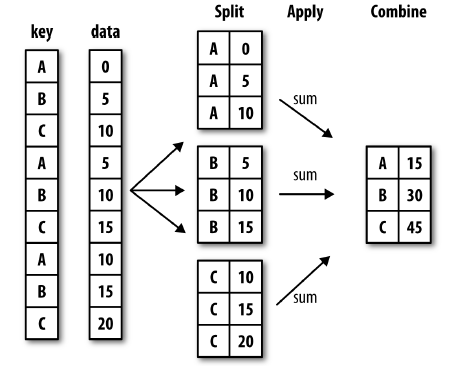


Grouping key can take many forms. Keys can be of different types:
1. A list of values having same length as the axis being grouped.
2. A value indicating column name in a DataFrame.
3. A dict or Series providing correspondence between values on the axis being grouped an group names.
4. A function to be invoked on axis index or individual labels in the index.

Note that last three methods are actually shortcuts for producing array of values to split up the object.

Don’t worry if this all seems abstract. Throughout this
module, you will see many examples of all these methods.

To get started, here is a small tabular dataset as a DataFrame:

In [1]:
import pandas as pd
import numpy as np

np.random.seed(8)

df = pd.DataFrame({'Student': ['a', 'a', 'b', 'b', 'a', 'b'],
                  'Course': ['210', '211', '210', '211', '210', '211'],
                  'Quiz1': np.random.randint(10, size=6),
                  'Quiz2': np.random.randint(10, size=6)})
df

,Student,Course,Quiz1,Quiz2
0,a,210,3,3
1,a,211,4,8
2,b,210,1,0
3,b,211,9,5
4,a,210,5,1
5,b,211,8,3


Suppose you wanted to compute the **mean** of the `Quiz1` column for each student (based on `Student` column). 

That means, we need to group the data by `Student` after selecting `Quiz1`:

In [2]:
grouped = df['Quiz1'].groupby(df['Student'])
grouped

This `grouped` variable is now a `GroupBy` *object*. It has not actually computed anything yet except for some intermediate data about the group key `df['Student']`. 

The idea is that this object has all of the information needed to then apply some operation to each of the groups. 

For example, to compute group means we can call the GroupBy’s `mean` method:

In [3]:
grouped.mean()

Student
a    4.0
b    6.0
Name: Quiz1, dtype: float64

The data (a Series) has been aggregated according to the group key (which is `Student`),
producing a new Series that is now indexed by the unique values in the `Student` column.

The result index has the name '`Student`' because the DataFrame column `df['Student']` did.

We could compute mean for students at course level as well. 

In this case, we need to group the data based on `Student` and `Course` as shown below.

This will produce a multi-index Series object:

In [4]:
means = df['Quiz1'].groupby([df['Student'], df['Course']]).mean()
means

Student  Course
a        210       4.0
         211       4.0
b        210       1.0
         211       8.5
Name: Quiz1, dtype: float64

Here we grouped the data using two keys, and the resulting Series now has a hierarchical
index consisting of the unique pairs of keys observed.

We can use `unstack` method to move the inner-level index as column:

In [8]:
means.unstack(1)

Course,210,211
Student,,
a,4.0,4.0
b,1.0,8.5


Frequently the grouping information is found in the same DataFrame as the data you
want to work on. 

In that case, you can pass column names (whether those are strings,
numbers, or other Python objects) as the group keys:

In [9]:
df.groupby('Student').mean()

,Quiz1,Quiz2
Student,,
a,4.0,4.000000
b,6.0,2.666667


In [11]:
df.groupby(['Course','Student']).mean()

Quiz1  Quiz2
Course Student              
210    a          4.0    2.0
       b          1.0    0.0
211    a          4.0    8.0
       b          8.5    4.0

You may have noticed in the first case `df.groupby('Student').mean(`) that there is no `key2` column in the result. Because `df['Course']` is not numeric data, it is therefore excluded from the result. 

By default, all of the numeric columns are aggregated, though it is possible to filter down to a subset, as you’ll see soon.

Regardless of the objective in using `groupby`, a generally useful GroupBy method is `size`, which returns a Series containing group sizes.

For example, the following output indicates how many times students took a quiz for each course.

In [12]:
df.groupby(by=['Student', 'Course']).size()

Student  Course
a        210       2
         211       1
b        210       1
         211       2
dtype: int64

According to the results, Student '`a`' has taken 2 quizzes (i.e., *2 rows*) in 210 and 1 quiz (i.e., *1 row*) in 211.

Take note that any missing values in a group key will be excluded from the result.

### 1.1. Iterating Over Groups

The `GroupBy` object supports iteration, generating a sequence of 2-tuples containing
the group name along with the chunk of data. 

Consider the following:

In [13]:
for name, group in df.groupby('Student'):
    print(name)
    print(group)

a
  Student Course  Quiz1  Quiz2
0       a    210      3      3
1       a    211      4      8
4       a    210      5      1
b
  Student Course  Quiz1  Quiz2
2       b    210      1      0
3       b    211      9      5
5       b    211      8      3


In the case of multiple keys, the first element in the tuple will be a tuple of key values:

In [14]:
for (k1, k2), group in df.groupby(['Student', 'Course']):
    print((k1, k2))
    print(group)

('a', '210')
  Student Course  Quiz1  Quiz2
0       a    210      3      3
4       a    210      5      1
('a', '211')
  Student Course  Quiz1  Quiz2
1       a    211      4      8
('b', '210')
  Student Course  Quiz1  Quiz2
2       b    210      1      0
('b', '211')
  Student Course  Quiz1  Quiz2
3       b    211      9      5
5       b    211      8      3


### 1.2. Selecting a Column or Subset of Columns

Indexing a `GroupBy` object created from a DataFrame with a column name or array of column names has the effect of column subsetting for aggregation. This means that:

In [15]:
df.groupby('Student')['Quiz1']
df.groupby('Student')[['Quiz2']]

are equalivant to:

In [16]:
df['Quiz1'].groupby(df['Student'])
df[['Quiz2']].groupby(df['Student'])

Especially for large datasets, it may be desirable to aggregate only a few columns. 

For example, in the preceding dataset, to compute means for just the `Quiz2` column and get the result as a DataFrame, we could write:

In [20]:
df.groupby(['Course','Student'])[['Quiz2']].mean()

Quiz2
Course Student       
210    a          2.0
       b          0.0
211    a          8.0
       b          4.0

Grouping information may exist in a form other than an array. 

Let’s consider another example DataFrame, which holds students GPA information for different semesters and years:

In [18]:
gpa = pd.DataFrame(np.random.randn(5,5)+2.5,
                        columns = ['2019F', '2019S', '2020F', '2020S', '2021F'],
                        index = ['Joe', 'Steve', 'Wes', 'Jim', 'Travis'])
gpa.iloc[2:3, [1,2]] = np.nan # a few NA values

gpa

,2019F,2019S,2020F,2020S,2021F
Joe,0.203508,4.909834,4.227836,4.704556,3.294828
Steve,3.476421,1.316573,4.416364,1.376673,1.835965
Wes,2.121641,NaN,NaN,2.269211,2.434339
Jim,2.291364,3.846869,1.893047,2.325752,2.924051
Travis,0.854010,2.016459,3.035468,3.666140,2.661683


Now, we have group correspondence for the columns. In other words, we have some specific year labels regardless the semester:

In [19]:
mapping = {'2019F': 'Sophomore', '2019S': 'Sophomore', '2020F': 'Junior',
          '2020S': 'Junior', '2021F': 'Senior', '2021S': 'Senior'}

Now, we can just pass the `dict` to `groupby` function to group students based on their year:

<sup>Pleaset note that the key `20221S` is included to highlight that unused grouping keys are OK.</sup>

In [21]:
gap_by_year = gpa.groupby(mapping, axis = 1)
gap_by_year.mean()

,Junior,Senior,Sophomore
Joe,4.466196,3.294828,2.556671
Steve,2.896518,1.835965,2.396497
Wes,2.269211,2.434339,2.121641
Jim,2.109399,2.924051,3.069116
Travis,3.350804,2.661683,1.435234


The same functionality holds for Series, which can be viewed as a fixed-size mapping:

In [22]:
map_series = pd.Series(mapping)

map_series

2019F    Sophomore
2019S    Sophomore
2020F       Junior
2020S       Junior
2021F       Senior
2021S       Senior
dtype: object

In [23]:
gpa.groupby(map_series, axis=1).count()

,Junior,Senior,Sophomore
Joe,2,1,2
Steve,2,1,2
Wes,1,1,1
Jim,2,1,2
Travis,2,1,2


### 1.3. Grouping with functions

It is also possible to pass a *function* to `groupby`. 

Any function passed is called once per **index value**. The returned values from the function are used to form the groups.

Consider the example DataFrame from the previous section, which has students’ first names as index values. 

Suppose you wanted to group students by the length of the names. To achieve this, (while you could compute an array of string lengths), you can simply  just pass the `len` function:

In [24]:
gpa.groupby(len).sum()

,2019F,2019S,2020F,2020S,2021F
3,4.616514,8.756703,6.120883,9.299519,8.653218
5,3.476421,1.316573,4.416364,1.376673,1.835965
6,0.854010,2.016459,3.035468,3.666140,2.661683


For the example above, it is important to note that if `by` is a function (such as `len`), it’s called on each value of the object’s **index**.

You can pass an array, dict, or Series object along with the function. 

For example, in the following we include students' department information in the final dataset:

In [25]:
key_list = ['CEIT', 'MATH', 'CEIT', 'PHYSICS', 'STATS']

gpa.groupby([len, key_list]).min()

2019F     2019S     2020F     2020S     2021F
3 CEIT     0.203508  4.909834  4.227836  2.269211  2.434339
  PHYSICS  2.291364  3.846869  1.893047  2.325752  2.924051
5 MATH     3.476421  1.316573  4.416364  1.376673  1.835965
6 STATS    0.854010  2.016459  3.035468  3.666140  2.661683

### 1.4. Grouping by Index Levels
A final convenience for hierarchically indexed datasets is the ability to aggregate
using one of the levels of an axis index. 

Let’s look at an example:

In [28]:
columns = pd.MultiIndex.from_arrays([
                                      ['CEIT210', 'CEIT210', 'CEIT210', 'CEIT211', 'CEIT211'],
                                      ['Exam1', 'Exam2', 'Final', 'Exam1', 'Exam2']
                                    ],
                                    names=['Course', 'Exam'])
exam_df = pd.DataFrame(np.random.randint(100, size=20).reshape(4,5), 
                       columns=columns, 
                       index=["A", 'B', 'C', 'D'])
exam_df.index.name = "Student"
exam_df

Course  CEIT210             CEIT211      
Exam      Exam1 Exam2 Final   Exam1 Exam2
Student                                  
A            55    55    20      98    87
B            98    24     6      28     5
C            66    19    99      75    11
D            46    92    72      55    89

To group by level, pass the level number or name using the `level` keyword.

Let's group data by `Course`:

In [29]:
exam_df.groupby(level = 'Course', axis = 'columns').mean()

Course,CEIT210,CEIT211
Student,,
A,43.333333,92.5
B,42.666667,16.5
C,61.333333,43.0
D,70.000000,72.0


Let's group data by `Exam`:

In [30]:
exam_df.groupby(level = 'Exam', axis = 1).mean()


Exam,Exam1,Exam2,Final
Student,,,
A,76.5,71.0,20.0
B,63.0,14.5,6.0
C,70.5,15.0,99.0
D,50.5,90.5,72.0


## 2. Data Aggregation



Aggregations refer to any data transformation that produces **scalar values from arrays**. 

The preceding examples have used several of them, including `mean`, `count`, `min`, and `sum`. 

You may wonder what is going on when you invoke `mean()` on a GroupBy object. Many common aggregations, such as those found in the following table, have optimized implementations. 

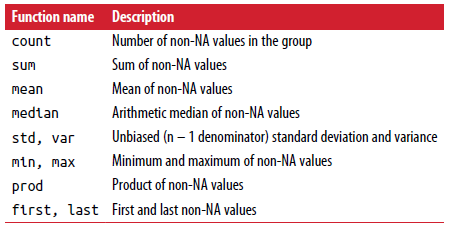

However, you are not limited to only this set of methods. You can use aggregations they you customly created and also you can call any method that is defined on the grouped object. 

For example, you might recall that *quantile* return values at the given quantile.

While `quantile` is not explicitly implemented for `groupby`, it can be still applied on chunks of data resulted from `groupby`. 

Let's compute quantiles for each student in the following dataset:

In [31]:
df

,Student,Course,Quiz1,Quiz2
0,a,210,3,3
1,a,211,4,8
2,b,210,1,0
3,b,211,9,5
4,a,210,5,1
5,b,211,8,3


In [32]:
grouped = df.groupby('Student')
grouped

In [33]:
grouped['Quiz1'].quantile([0.25, 0.5, 0.75])

Student      
a        0.25    3.5
         0.50    4.0
         0.75    4.5
b        0.25    4.5
         0.50    8.0
         0.75    8.5
Name: Quiz1, dtype: float64

To use your own aggregation functions, pass any function that aggregates an array to the aggregate or agg method:

In [34]:
def minMaxDiff(arr):
    return arr.max() - arr.min()

grouped[['Quiz1', 'Quiz2']].agg(minMaxDiff)

,Quiz1,Quiz2
Student,,
a,2,7
b,8,5


### 2.1. Column-Wise and Multiple Function Application
Let’s return to the `tipping` dataset from earlier examples. After loading it with `read_csv`, we add a tipping percentage column `tip_pct`:


In [36]:
tips = pd.read_csv('tips.csv')
tips['tip_pct'] = tips['tip'] / tips['total_bill']

tips[:6]

,total_bill,tip,smoker,day,time,size,tip_pct
0,16.99,1.01,No,Sun,Dinner,2,0.059447
1,10.34,1.66,No,Sun,Dinner,3,0.160542
2,21.01,3.50,No,Sun,Dinner,3,0.166587
3,23.68,3.31,No,Sun,Dinner,2,0.139780
4,24.59,3.61,No,Sun,Dinner,4,0.146808
5,25.29,4.71,No,Sun,Dinner,4,0.186240


As you’ve already seen, aggregating a Series or all of the columns of a DataFrame is a matter of using `aggregate` with the desired function or calling a method like `mean` or `std`. 

However, you may want to aggregate using a *different function* depending on the *column*, or *multiple functions* at once. 

Fortunately, this is possible to do, which will be illustrated through a number of examples. 

First, we’ll group the `tips` by `day` and `smoker`:

In [37]:
grouped = tips.groupby(['day', 'smoker'])
grouped_pct = grouped['tip_pct']
grouped_pct

Note that for descriptive statistics, you can pass the name of the function as a string:

In [38]:
grouped_pct.agg('mean')

day   smoker
Fri   No        0.151650
      Yes       0.174783
Sat   No        0.158048
      Yes       0.147906
Sun   No        0.160113
      Yes       0.187250
Thur  No        0.160298
      Yes       0.163863
Name: tip_pct, dtype: float64

If you pass a list of functions or function names instead, you get back a DataFrame
with column names taken from the functions:

In [39]:
grouped_pct.agg([np.mean, 'std', minMaxDiff])

mean       std  minMaxDiff
day  smoker                                
Fri  No      0.151650  0.028123    0.067349
     Yes     0.174783  0.051293    0.159925
Sat  No      0.158048  0.039767    0.235193
     Yes     0.147906  0.061375    0.290095
Sun  No      0.160113  0.042347    0.193226
     Yes     0.187250  0.154134    0.644685
Thur No      0.160298  0.038774    0.193350
     Yes     0.163863  0.039389    0.151240

Here we passed a list of aggregation functions to `agg` to evaluate indepedently on the data groups.

if you pass a list of (name, function) tuples, the first element of each tuple will be used as the DataFrame column names (you can think of a list of 2-tuples as an ordered mapping):

In [41]:
grouped_pct.agg([('Average', np.mean), ('Stand. Dev.','std'), ('Max-Min', minMaxDiff)])

Average  Stand. Dev.   Max-Min
day  smoker                                 
Fri  No      0.151650     0.028123  0.067349
     Yes     0.174783     0.051293  0.159925
Sat  No      0.158048     0.039767  0.235193
     Yes     0.147906     0.061375  0.290095
Sun  No      0.160113     0.042347  0.193226
     Yes     0.187250     0.154134  0.644685
Thur No      0.160298     0.038774  0.193350
     Yes     0.163863     0.039389  0.151240

You can specify a list of functions to apply to all of the columns or different functions per column. 

To start, suppose we wanted to compute the same three statistics for the `tip_pct` and `total_bill` columns:

In [42]:
functions = ['count', 'mean', 'max']
result = grouped['tip_pct', 'total_bill'].agg(functions)
result

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


tip_pct                     total_bill                  
              count      mean       max      count       mean    max
day  smoker                                                         
Fri  No           4  0.151650  0.187735          4  18.420000  22.75
     Yes         15  0.174783  0.263480         15  16.813333  40.17
Sat  No          45  0.158048  0.291990         45  19.661778  48.33
     Yes         42  0.147906  0.325733         42  21.276667  50.81
Sun  No          57  0.160113  0.252672         57  20.506667  48.17
     Yes         19  0.187250  0.710345         19  24.120000  45.35
Thur No          45  0.160298  0.266312         45  17.113111  41.19
     Yes         17  0.163863  0.241255         17  19.190588  43.11

As you can see, the resulting DataFrame has hierarchical columns, the same as you
would get aggregating each column separately and using `concat` to glue the results
together using the column names as the keys argument:

In [43]:
result['tip_pct']

count      mean       max
day  smoker                           
Fri  No          4  0.151650  0.187735
     Yes        15  0.174783  0.263480
Sat  No         45  0.158048  0.291990
     Yes        42  0.147906  0.325733
Sun  No         57  0.160113  0.252672
     Yes        19  0.187250  0.710345
Thur No         45  0.160298  0.266312
     Yes        17  0.163863  0.241255

As before, a list of tuples with custom names can be passed:

In [44]:
ftuples = [('average', 'mean'), ('variance', np.var)]

grouped['tip_pct', 'total_bill'].agg(ftuples)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


tip_pct           total_bill            
              average  variance    average    variance
day  smoker                                           
Fri  No      0.151650  0.000791  18.420000   25.596333
     Yes     0.174783  0.002631  16.813333   82.562438
Sat  No      0.158048  0.001581  19.661778   79.908965
     Yes     0.147906  0.003767  21.276667  101.387535
Sun  No      0.160113  0.001793  20.506667   66.099980
     Yes     0.187250  0.023757  24.120000  109.046044
Thur No      0.160298  0.001503  17.113111   59.625081
     Yes     0.163863  0.001551  19.190588   69.808518

Now, suppose you wanted to apply potentially different functions to one or more of the columns. 

To do this, pass a `dict` to `agg` that contains a mapping of column names
to any of the function specifications listed so far.

For example, the following statement finds the maximum value for `tip` column, and the sum for the `size` column:

In [45]:
grouped.agg({'tip': np.max, 'size': 'sum'})

tip  size
day  smoker             
Fri  No       3.50     9
     Yes      4.73    31
Sat  No       9.00   115
     Yes     10.00   104
Sun  No       6.00   167
     Yes      6.50    49
Thur No       6.70   112
     Yes      5.00    40

As another example, the following statement computes minimum, maximum, average, and standard deviation values for the `top_pct` column and the sum for the `size` column:

In [46]:
grouped.agg({'tip_pct': ['min', 'max', 'mean', 'std'],
            'size': 'sum'})

tip_pct                               size
                  min       max      mean       std  sum
day  smoker                                             
Fri  No      0.120385  0.187735  0.151650  0.028123    9
     Yes     0.103555  0.263480  0.174783  0.051293   31
Sat  No      0.056797  0.291990  0.158048  0.039767  115
     Yes     0.035638  0.325733  0.147906  0.061375  104
Sun  No      0.059447  0.252672  0.160113  0.042347  167
     Yes     0.065660  0.710345  0.187250  0.154134   49
Thur No      0.072961  0.266312  0.160298  0.038774  112
     Yes     0.090014  0.241255  0.163863  0.039389   40

A DataFrame will have hierarchical columns only if multiple functions are applied to at least one column.

### 2.2. Returning Aggregated Data without Row Indexes

In all of the examples up until now, the aggregated data comes back with an index,
potentially hierarchical, composed from the unique group key combinations. 

Since this isn’t always desirable, you can disable this behavior in most cases by passing `as_index=False` to groupby:

In [47]:
tips.groupby(['day', 'smoker'], as_index=False).mean()

,day,smoker,total_bill,tip,size,tip_pct
0,Fri,No,18.420000,2.812500,2.250000,0.151650
1,Fri,Yes,16.813333,2.714000,2.066667,0.174783
2,Sat,No,19.661778,3.102889,2.555556,0.158048
3,Sat,Yes,21.276667,2.875476,2.476190,0.147906
4,Sun,No,20.506667,3.167895,2.929825,0.160113
5,Sun,Yes,24.120000,3.516842,2.578947,0.187250
6,Thur,No,17.113111,2.673778,2.488889,0.160298
7,Thur,Yes,19.190588,3.030000,2.352941,0.163863


Of course, it’s always possible to obtain the result in this format by calling `reset_index` on the result. Using the `as_index=False` method avoids some unnecessary computations.

## 3. Apply function

The most general-purpose GroupBy method is `apply`, which is the subject of the rest of this section. 

`apply` splits the object being manipulated into pieces, invokes the passed function on each piece, and then attempts to concatenate the pieces together.

Returning to the `tipping` dataset from before, suppose you wanted to select the top five `tip_pct` values by group. 

First, write a function that selects the rows with the largest values in a particular column:

In [52]:
def top(df, n=5, column='tip_pct'):
    return df.sort_values(by=column, ascending = False)[:n]

top(tips)

,total_bill,tip,smoker,day,time,size,tip_pct
172,7.25,5.15,Yes,Sun,Dinner,2,0.710345
178,9.60,4.00,Yes,Sun,Dinner,2,0.416667
67,3.07,1.00,Yes,Sat,Dinner,1,0.325733
232,11.61,3.39,No,Sat,Dinner,2,0.291990
183,23.17,6.50,Yes,Sun,Dinner,4,0.280535


In [ ]:
top(tips, n=6)

Now, if we group by `smoker`, say, and call `apply` with this function, we get the following:

In [53]:
tips.groupby('smoker').apply(top)

total_bill   tip smoker   day    time  size   tip_pct
smoker                                                           
No     232       11.61  3.39     No   Sat  Dinner     2  0.291990
       149        7.51  2.00     No  Thur   Lunch     2  0.266312
       51        10.29  2.60     No   Sun  Dinner     2  0.252672
       185       20.69  5.00     No   Sun  Dinner     5  0.241663
       88        24.71  5.85     No  Thur   Lunch     2  0.236746
Yes    172        7.25  5.15    Yes   Sun  Dinner     2  0.710345
       178        9.60  4.00    Yes   Sun  Dinner     2  0.416667
       67         3.07  1.00    Yes   Sat  Dinner     1  0.325733
       183       23.17  6.50    Yes   Sun  Dinner     4  0.280535
       109       14.31  4.00    Yes   Sat  Dinner     2  0.279525

What has happened here? The top function is called on each row group from the DataFrame, and then the results are glued together using `pandas.concat`, labeling the pieces with the group names. 

The result therefore has a hierarchical index whose inner level contains index values from the original DataFrame.

If you pass a function to `apply` that takes other arguments or keywords, you can pass these after the function.

Let's find the *highest* bill on *different days* per each *group* of `smoker`.

In [54]:
tips.groupby(['smoker', 'day']).apply(top, n=1, column = 'total_bill')

total_bill    tip smoker   day    time  size   tip_pct
smoker day                                                             
No     Fri  94        22.75   3.25     No   Fri  Dinner     2  0.142857
       Sat  212       48.33   9.00     No   Sat  Dinner     4  0.186220
       Sun  156       48.17   5.00     No   Sun  Dinner     6  0.103799
       Thur 142       41.19   5.00     No  Thur   Lunch     5  0.121389
Yes    Fri  95        40.17   4.73    Yes   Fri  Dinner     4  0.117750
       Sat  170       50.81  10.00    Yes   Sat  Dinner     3  0.196812
       Sun  182       45.35   3.50    Yes   Sun  Dinner     3  0.077178
       Thur 197       43.11   5.00    Yes  Thur   Lunch     4  0.115982

Inside `groupby`, when you want to invoke a method, there is a shortcut for it.

In [55]:
# Normal route
result = grouped.describe()

result

total_bill                                                        \
                 count       mean        std    min     25%     50%      75%   
day  smoker                                                                    
Fri  No            4.0  18.420000   5.059282  12.46  15.100  19.235  22.5550   
     Yes          15.0  16.813333   9.086388   5.75  11.690  13.420  18.6650   
Sat  No           45.0  19.661778   8.939181   7.25  14.730  17.820  20.6500   
     Yes          42.0  21.276667  10.069138   3.07  13.405  20.390  26.7925   
Sun  No           57.0  20.506667   8.130189   8.77  14.780  18.430  25.0000   
     Yes          19.0  24.120000  10.442511   7.25  17.165  23.100  32.3750   
Thur No           45.0  17.113111   7.721728   7.51  11.690  15.950  20.2700   
     Yes          17.0  19.190588   8.355149  10.34  13.510  16.470  19.8100   

                     tip            ...  size      tip_pct            \
               max count      mean  ...   75%  max   count      mean   
day  smoker                         ...                                
Fri  No      22.75   4.0  2.812500  ...  2.25  3.0     4.0  0.151650   
     Yes     40.17  15.0  2.714000  ...  2.00  4.0    15.0  0.174783   
Sat  No      48.33  45.0  3.102889  ...  3.00  4.0    45.0  0.158048   
     Yes     50.81  42.0  2.875476  ...  3.00  5.0    42.0  0.147906   
Sun  No      48.17  57.0  3.167895  ...  4.00  6.0    57.0  0.160113   
     Yes     45.35  19.0  3.516842  ...  3.00  5.0    19.0  0.187250   
Thur No      41.19  45.0  2.673778  ...  2.00  6.0    45.0  0.160298   
     Yes     43.11  17.0  3.030000  ...  2.00  4.0    17.0  0.163863   

                                                                         
                  std       min       25%       50%       75%       max  
day  smoker                                                              
Fri  No      0.028123  0.120385  0.137239  0.149241  0.163652  0.187735  
     Yes     0.051293  0.103555  0.133739  0.173913  0.209240  0.263480  
Sat  No      0.039767  0.056797  0.136240  0.150152  0.183915  0.291990  
     Yes     0.061375  0.035638  0.091797  0.153624  0.190502  0.325733  
Sun  No      0.042347  0.059447  0.139780  0.161665  0.185185  0.252672  
     Yes     0.154134  0.065660  0.097723  0.138122  0.215325  0.710345  
Thur No      0.038774  0.072961  0.137741  0.153492  0.184843  0.266312  
     Yes     0.039389  0.090014  0.148038  0.153846  0.194837  0.241255  

[8 rows x 32 columns]

In [56]:
result.stack(1)

total_bill       tip  size   tip_pct
day  smoker                                            
Fri  No     count    4.000000  4.000000  4.00  4.000000
            mean    18.420000  2.812500  2.25  0.151650
            std      5.059282  0.898494  0.50  0.028123
            min     12.460000  1.500000  2.00  0.120385
            25%     15.100000  2.625000  2.00  0.137239
...                       ...       ...   ...       ...
Thur Yes    min     10.340000  2.000000  2.00  0.090014
            25%     13.510000  2.000000  2.00  0.148038
            50%     16.470000  2.560000  2.00  0.153846
            75%     19.810000  4.000000  2.00  0.194837
            max     43.110000  5.000000  4.00  0.241255

[64 rows x 4 columns]

In [57]:
# Shortcut
f = lambda x: x.describe()
grouped.apply(f)

total_bill       tip  size   tip_pct
day  smoker                                            
Fri  No     count    4.000000  4.000000  4.00  4.000000
            mean    18.420000  2.812500  2.25  0.151650
            std      5.059282  0.898494  0.50  0.028123
            min     12.460000  1.500000  2.00  0.120385
            25%     15.100000  2.625000  2.00  0.137239
...                       ...       ...   ...       ...
Thur Yes    min     10.340000  2.000000  2.00  0.090014
            25%     13.510000  2.000000  2.00  0.148038
            50%     16.470000  2.560000  2.00  0.153846
            75%     19.810000  4.000000  2.00  0.194837
            max     43.110000  5.000000  4.00  0.241255

[64 rows x 4 columns]

### 3.1. Quantile and Bucket Analysis

As you may recall from previous modules, `pandas` has some tools, in particular `cut` and `qcut`, for slicing data up into buckets with bins of your choosing or by sample quantiles.

Combining these functions with groupby makes it convenient to perform bucket or quantile analysis on a dataset. 

Consider a simple random dataset and an equal-length bucket categorization using cut:

In [58]:
frame = pd.DataFrame({'data1': np.random.randn(1000),
                     'data2': np.random.randn(1000)})
frame.head()

,data1,data2
0,-0.672834,-0.320102
1,0.332517,1.341974
2,-0.518080,-0.057726
3,-1.035037,-1.024937
4,-0.011980,-0.493275


In [63]:
quartiles = pd.cut(frame.data1, 4)
quartiles[:10]

0    (-1.491, -0.0522]
1     (-0.0522, 1.387]
2    (-1.491, -0.0522]
3    (-1.491, -0.0522]
4     (-0.0522, 1.387]
5    (-1.491, -0.0522]
6    (-1.491, -0.0522]
7     (-0.0522, 1.387]
8    (-1.491, -0.0522]
9     (-2.936, -1.491]
Name: data1, dtype: category
Categories (4, interval[float64, right]): [(-2.936, -1.491] < (-1.491, -0.0522] < (-0.0522, 1.387] <
                                           (1.387, 2.826]]

The Categorical object returned by `cut` can be passed directly to `groupby`.

For example, we can group students basedon these categories (produced by `cut`) and compute mean of `data2` per each group:

In [64]:
frame.data2.groupby(quartiles).mean()

data1
(-2.936, -1.491]    -0.035890
(-1.491, -0.0522]    0.067711
(-0.0522, 1.387]    -0.032131
(1.387, 2.826]      -0.009271
Name: data2, dtype: float64

We can also compute a set of statistics for the `data2` column like so:

In [65]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
           'count': group.count(), 'mean': group.mean()}

grouped = frame.data2.groupby(quartiles)
grouped.apply(get_stats)

data1                   
(-2.936, -1.491]   min       -2.293112
                   max        2.202061
                   count     72.000000
                   mean      -0.035890
(-1.491, -0.0522]  min       -3.210107
                   max        3.539511
                   count    422.000000
                   mean       0.067711
(-0.0522, 1.387]   min       -3.294269
                   max        2.676837
                   count    431.000000
                   mean      -0.032131
(1.387, 2.826]     min       -2.228685
                   max        1.605132
                   count     75.000000
                   mean      -0.009271
Name: data2, dtype: float64

In [66]:
grouped.apply(get_stats).unstack(1)

,min,max,count,mean
data1,,,,
"(-2.936, -1.491]",-2.293112,2.202061,72.0,-0.035890
"(-1.491, -0.0522]",-3.210107,3.539511,422.0,0.067711
"(-0.0522, 1.387]",-3.294269,2.676837,431.0,-0.032131
"(1.387, 2.826]",-2.228685,1.605132,75.0,-0.009271


These were equal-length buckets; to compute equal-size buckets based on sample quantiles, use `qcut`. 

That is, with `qcut` each category will include the same number of data points.

You can pass `labels=False` to just get quantile numbers:

In [68]:
grouping = pd.qcut(frame.data1, 10)
grouped = frame.data2.groupby(grouping)
grouped.apply(get_stats).unstack()

,min,max,count,mean
data1,,,,
"(-2.931, -1.266]",-2.293112,2.202061,100.0,0.059067
"(-1.266, -0.807]",-2.539775,3.539511,100.0,0.115326
"(-0.807, -0.511]",-3.210107,2.524813,100.0,0.185600
"(-0.511, -0.253]",-2.553363,2.625187,100.0,-0.097091
"(-0.253, -0.0288]",-2.702126,2.473546,100.0,0.007704
"(-0.0288, 0.223]",-3.294269,2.622189,100.0,-0.039952
"(0.223, 0.491]",-2.407814,1.622238,100.0,-0.117944
"(0.491, 0.772]",-2.528075,1.982304,100.0,-0.059250
"(0.772, 1.191]",-2.710019,2.676837,100.0,0.044454


### 3.2. Example: Filling Missing Values with Group-Specific Values

When cleaning up missing data, in some cases you will replace data observations using `dropna`, but in others you may want to impute (fill in) the null (NA) values using a fixed value or some value derived from the data. 

`fillna` is the right tool to use; for example, here I fill in NA values with the mean:

In [69]:
s = pd.Series(np.random.randn(6))
s[::2] = np.nan
s

0         NaN
1    0.510751
2         NaN
3    1.460317
4         NaN
5   -0.317087
dtype: float64

In [70]:
s.fillna(s.mean())

0    0.551327
1    0.510751
2    0.551327
3    1.460317
4    0.551327
5   -0.317087
dtype: float64

Sometimes the value to fill missing values may vary by group. 

In such cases, one way to do this is to group the data and use apply with a function that calls `fillna` on each data chunk. 

Here is some sample data on US states divided into eastern and western regions:

In [71]:
states = ['Ohio', 'New York', 'Vermont', 'Florida',
         'Oregon', 'Nevada', 'California', 'Idaho']
region = group_key = ['East'] * 4 + ['West'] * 4

data = pd.DataFrame({'Key':[15, 10, np.nan, 30, np.nan, 10, 15, 6]}, index=[region, states])
data.index.names = ["Region", "State"]
data

Key
Region State           
East   Ohio        15.0
       New York    10.0
       Vermont      NaN
       Florida     30.0
West   Oregon       NaN
       Nevada      10.0
       California  15.0
       Idaho        6.0

In [72]:
data.groupby('Region').mean()

,Key
Region,
East,18.333333
West,10.333333


We can fill the NA values using the group means like so:

In [73]:
# setting the NA values with group means

fill_name = lambda g: g.fillna(g.mean())

In [74]:
data.groupby('Region').apply(fill_name)

Key
Region State                
East   Ohio        15.000000
       New York    10.000000
       Vermont     18.333333
       Florida     30.000000
West   Oregon      10.333333
       Nevada      10.000000
       California  15.000000
       Idaho        6.000000

In another case, you might have predefined fill values in your code that vary by group. 

Since the groups have a name attribute set internally, we can use that:

In [75]:
fill_values = {'East': 0.5, 'West': -1}
fill_func = lambda g: g.fillna(fill_values[g.name])

data.groupby('Region').apply(fill_func)

Key
Region State           
East   Ohio        15.0
       New York    10.0
       Vermont      0.5
       Florida     30.0
West   Oregon      -1.0
       Nevada      10.0
       California  15.0
       Idaho        6.0

### 3.3. In-class Exercise: Correlation

In this exercise, we will work on a dataset about students' visits to different modules on different course day and week.

In [77]:
module_visits = pd.read_excel('module-visits.xlsx', index_col = [1,0])

module_visits.head()

Module1  Module2  Module3  Module4
Week Day                                    
1    1         16       12        7       16
     2         20       13       14        3
     3         15        5        2        4
     4          3       15        3       16
     5          2        6       18       17

In [78]:
module_visits[-4:]

Module1  Module2  Module3  Module4
Week Day                                    
9    57        12        8        3        8
     58        14        1       18        1
     59        14       12        2       12
     60        18       12        8       15

What we are interested in is the correlation between `Module4` visits and the visits to the previous modules.

To compute this, we create the following function:

In [79]:
m4_corr = lambda x: x.corrwith(x['Module4'])

We can pass our dataframe to this function to get the correlations between module visits:

In [80]:
m4_corr(module_visits)

Module1   -0.301003
Module2    0.232900
Module3   -0.125626
Module4    1.000000
dtype: float64

However, we want to compute the correlations per each week separately.

To do so, we need to group the dat by `Week` and the **`apply`** the `m4_corr` function.


In [81]:
by_week = module_visits.groupby('Week')
by_week.apply(m4_corr)

,Module1,Module2,Module3,Module4
Week,,,,
1,-0.540158,0.564338,0.325930,1.0
2,-0.352104,0.470367,-0.305948,1.0
3,0.203703,-0.823183,-0.432955,1.0
4,-0.824513,-0.301856,-0.241102,1.0
5,-0.626101,0.591025,-0.341192,1.0
6,0.209614,0.513927,0.077113,1.0
7,-0.364906,0.528120,-0.538507,1.0
8,-0.440953,0.623776,0.591939,1.0
9,0.568722,0.976158,-0.699377,1.0


You could also compute inter-column correlations. 

Here we can write a lambda function to compute the weekly correlation between `Module1` and `Module2`:

In [82]:
by_week.apply(lambda g: g['Module1'].corr(g['Module2']))

Week
1    0.080864
2   -0.156850
3   -0.621721
4   -0.196533
5   -0.154947
6    0.253696
7    0.113194
8   -0.083356
9    0.395716
dtype: float64

## 4. Pivot Tables and Cross-Tabulation

We have covered pivot tables in the previous modulue. In this module, we will work on some additional exercises focusing on the `pivot_table` function.

Actually, pivot tables in Python with pandas are made possible through `groupby` (which we covered in this module) combined with `reshape` operations utilizing *hierarchical indexing*. 

DataFrame has a `pivot_table` method, and there is also a top-level `pandas.pivot_table` function. 

In this section, we will work on `course_components.xlsx` data which contains specific information about the visits to different types of course components.

In [83]:
components = pd.read_excel('course-components.xlsx', index_col=[0])
components.head(2)

,Type,Module,Visits,FirstTimeVisited,LastTimeVisited,Difficulty
ID,,,,,,
1,Video,4,9,3,7,Easy
2,Quiz,4,51,3,5,Moderate


Let's group data by `Module` and `Type`, and then for each group compute the mean of `FirstTimeVisted`,	`LastTimeVisited`, and	`Visits` columns.

In [84]:
components.groupby(['Module', 'Type']).mean()

Visits  FirstTimeVisited  LastTimeVisited
Module Type                                                    
1      Assignment  22.500000          3.000000         6.500000
       Discussion  66.000000          4.000000         5.000000
       PDF         60.800000          3.000000         5.600000
       Quiz        87.000000          2.000000         7.000000
       Video       31.666667          2.666667         5.666667
2      Assignment  46.000000          2.500000         6.000000
       PDF         41.000000          2.250000         6.500000
       Quiz        22.000000          3.500000         6.500000
       Video        7.000000          3.000000         7.000000
3      Assignment  48.666667          3.333333         6.000000
       External    45.333333          1.333333         7.333333
       PDF         45.500000          2.333333         6.666667
       Quiz        43.166667          2.166667         6.500000
       Video       53.222222          2.333333         6.333333
4      Assignment  38.666667          2.000000         7.000000
       External    51.000000          3.000000         5.000000
       PDF         26.000000          3.000000         7.000000
       Quiz        42.666667          2.666667         6.000000
       Video       47.666667          2.666667         7.666667
5      Assignment  46.200000          2.600000         7.000000
       External     1.000000          2.000000         8.000000
       PDF          7.000000          3.000000         6.000000
       Quiz        42.000000          3.000000         7.000000
       Video       73.666667          3.333333         7.333333

This is also possible to do with `pivot_table`, in which you need to use `index` argument for grouping:

In [85]:
components.pivot_table(index = ['Module', 'Type'])

FirstTimeVisited  LastTimeVisited     Visits
Module Type                                                    
1      Assignment          3.000000         6.500000  22.500000
       Discussion          4.000000         5.000000  66.000000
       PDF                 3.000000         5.600000  60.800000
       Quiz                2.000000         7.000000  87.000000
       Video               2.666667         5.666667  31.666667
2      Assignment          2.500000         6.000000  46.000000
       PDF                 2.250000         6.500000  41.000000
       Quiz                3.500000         6.500000  22.000000
       Video               3.000000         7.000000   7.000000
3      Assignment          3.333333         6.000000  48.666667
       External            1.333333         7.333333  45.333333
       PDF                 2.333333         6.666667  45.500000
       Quiz                2.166667         6.500000  43.166667
       Video               2.333333         6.333333  53.222222
4      Assignment          2.000000         7.000000  38.666667
       External            3.000000         5.000000  51.000000
       PDF                 3.000000         7.000000  26.000000
       Quiz                2.666667         6.000000  42.666667
       Video               2.666667         7.666667  47.666667
5      Assignment          2.600000         7.000000  46.200000
       External            2.000000         8.000000   1.000000
       PDF                 3.000000         6.000000   7.000000
       Quiz                3.000000         7.000000  42.000000
       Video               3.333333         7.333333  73.666667

Now, suppose we want to compute the average of both `FirstTimeVisited` and `LastTimeVisited` values per each `Difficulty` level for different groups determined by the `Module` (that the component belongs to) and the `Type` of the component.

In [86]:
components.pivot_table(index = ['Module', 'Type'],
                       columns = 'Difficulty',
                       values = ['FirstTimeVisited', 'LastTimeVisited' ])

FirstTimeVisited                     LastTimeVisited  \
Difficulty               Difficult      Easy  Moderate       Difficult   
Module Type                                                              
1      Assignment         4.000000       NaN  2.000000        6.000000   
       Discussion         4.000000       NaN       NaN        5.000000   
       PDF                4.000000  2.750000       NaN        5.000000   
       Quiz                    NaN  2.000000       NaN             NaN   
       Video                   NaN  2.666667       NaN             NaN   
2      Assignment         2.000000  3.000000       NaN        7.000000   
       PDF                     NaN  2.500000  2.000000             NaN   
       Quiz                    NaN  3.500000       NaN             NaN   
       Video              3.000000       NaN       NaN        7.000000   
3      Assignment         3.500000  3.500000  3.000000        5.500000   
       External           1.000000  2.000000  1.000000        7.000000   
       PDF                2.333333       NaN  2.333333        6.000000   
       Quiz                    NaN  2.000000  2.333333             NaN   
       Video              2.400000  2.500000  2.000000        6.400000   
4      Assignment         3.000000  2.000000  1.000000        5.000000   
       External                NaN  3.000000  3.000000             NaN   
       PDF                     NaN       NaN  3.000000             NaN   
       Quiz               2.500000       NaN  3.000000        6.500000   
       Video              2.000000  3.000000  3.000000        8.000000   
5      Assignment         2.000000  3.500000       NaN        7.333333   
       External           2.000000       NaN       NaN        8.000000   
       PDF                     NaN       NaN  3.000000             NaN   
       Quiz               2.500000  4.000000       NaN        6.500000   
       Video              3.000000  4.000000  3.000000        6.000000   

                                       
Difficulty             Easy  Moderate  
Module Type                            
1      Assignment       NaN  7.000000  
       Discussion       NaN       NaN  
       PDF         5.750000       NaN  
       Quiz        7.000000       NaN  
       Video       5.666667       NaN  
2      Assignment  5.000000       NaN  
       PDF         6.000000  7.000000  
       Quiz        6.500000       NaN  
       Video            NaN       NaN  
3      Assignment  6.500000  6.000000  
       External    8.000000  7.000000  
       PDF              NaN  7.333333  
       Quiz        6.333333  6.666667  
       Video       5.500000  7.000000  
4      Assignment  8.000000  8.000000  
       External    5.000000  5.000000  
       PDF              NaN  7.000000  
       Quiz             NaN  5.000000  
       Video       7.000000  8.000000  
5      Assignment  6.500000       NaN  
       External         NaN       NaN  
       PDF              NaN  6.000000  
       Quiz        8.000000       NaN  
       Video       8.000000  8.000000

We can easily insert a total / sum row to our Python pivot table by using the `margins` and `margin_names` parameters. 

The margins parameters insets the summary row and columns. The `margin_names` parameters, allows us to rename the pivot table summary columns.

In the following code, we want to compute the average `Visits` per each `Difficulty` level on the data grouped by `Module`.

In [87]:
components.pivot_table(values=['Visits'], 
                       index=['Module'], 
                       columns='Difficulty', 
                       margins=True, margins_name='Mean (All)')

Visits                                 
Difficulty  Difficult       Easy   Moderate Mean (All)
Module                                                
1           60.000000  51.375000   6.000000  49.750000
2           46.000000  29.800000  33.000000  34.111111
3           52.454545  48.500000  43.090909  47.966667
4           33.500000  53.333333  44.200000  42.916667
5           40.000000  52.500000  34.333333  42.357143
Mean (All)  46.777778  47.071429  39.545455  44.818182

To use a different aggregation function, pass it to `aggfunc`. For example, `count` or `len` will give you a cross-tabulation (count or frequency) of group sizes.

For example, we can obtain the number of components with different difficulty levels for Type within each module:

In [88]:
components.pivot_table(index = ['Module', 'Type'],
                       columns = 'Difficulty',
                       values = 'Visits', aggfunc = 'count')

Difficulty         Difficult  Easy  Moderate
Module Type                                 
1      Assignment        1.0   NaN       1.0
       Discussion        1.0   NaN       NaN
       PDF               1.0   4.0       NaN
       Quiz              NaN   1.0       NaN
       Video             NaN   3.0       NaN
2      Assignment        1.0   1.0       NaN
       PDF               NaN   2.0       2.0
       Quiz              NaN   2.0       NaN
       Video             1.0   NaN       NaN
3      Assignment        2.0   2.0       2.0
       External          1.0   1.0       1.0
       PDF               3.0   NaN       3.0
       Quiz              NaN   3.0       3.0
       Video             5.0   2.0       2.0
4      Assignment        1.0   1.0       1.0
       External          NaN   1.0       1.0
       PDF               NaN   NaN       1.0
       Quiz              2.0   NaN       1.0
       Video             1.0   1.0       1.0
5      Assignment        3.0   2.0       NaN
       External          1.0   NaN       NaN
       PDF               NaN   NaN       2.0
       Quiz              2.0   1.0       NaN
       Video             1.0   1.0       1.0

If some combinations are empty (or otherwise `NA`), you may wish to pass a
`fill_value`:

In [89]:
components.pivot_table(values='Visits', index=['Module', 'Type'], 
                       columns='Difficulty', aggfunc=len, fill_value=0)

Difficulty         Difficult  Easy  Moderate
Module Type                                 
1      Assignment          1     0         1
       Discussion          1     0         0
       PDF                 1     4         0
       Quiz                0     1         0
       Video               0     3         0
2      Assignment          1     1         0
       PDF                 0     2         2
       Quiz                0     2         0
       Video               1     0         0
3      Assignment          2     2         2
       External            1     1         1
       PDF                 3     0         3
       Quiz                0     3         3
       Video               5     2         2
4      Assignment          1     1         1
       External            0     1         1
       PDF                 0     0         1
       Quiz                2     0         1
       Video               1     1         1
5      Assignment          3     2         0
       External            1     0         0
       PDF                 0     0         2
       Quiz                2     1         0
       Video               1     1         1

### 4.1. Cross-Tabulations: Crosstab
A cross-tabulation (or crosstab for short) is a special case of a pivot table that computes
group frequencies. 

For example, in the previous dataset, you can use `pivot_table` to compute the count of difficult vs easy for each type of component at different modules.

But, this can be done in an easire way using `pandas.crosstab`.

In [90]:
pd.crosstab(components.Type, components.Difficulty, margins=True)

Difficulty,Difficult,Easy,Moderate,All
Type,,,,
Assignment,8,6,4,18
Discussion,1,0,0,1
External,2,2,2,6
PDF,4,6,8,18
Quiz,4,7,4,15
Video,8,7,4,19
All,27,28,22,77


The first two arguments to `crosstab` can each either be an array or Series or a list of arrays. 

In [91]:
pd.crosstab([components['Module'],components['Type']], components['Difficulty'] , margins = True )

Difficulty         Difficult  Easy  Moderate  All
Module Type                                      
1      Assignment          1     0         1    2
       Discussion          1     0         0    1
       PDF                 1     4         0    5
       Quiz                0     1         0    1
       Video               0     3         0    3
2      Assignment          1     1         0    2
       PDF                 0     2         2    4
       Quiz                0     2         0    2
       Video               1     0         0    1
3      Assignment          2     2         2    6
       External            1     1         1    3
       PDF                 3     0         3    6
       Quiz                0     3         3    6
       Video               5     2         2    9
4      Assignment          1     1         1    3
       External            0     1         1    2
       PDF                 0     0         1    1
       Quiz                2     0         1    3
       Video               1     1         1    3
5      Assignment          3     2         0    5
       External            1     0         0    1
       PDF                 0     0         2    2
       Quiz                2     1         0    3
       Video               1     1         1    3
All                       27    28        22   77